In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Dropout, SimpleRNN, LSTM, Bidirectional, GRU
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import gensim.downloader as api
import pandas as pd
import numpy as np
import pickle
import ast
import keras
from keras import ops
from keras import layers
from kerastuner.tuners import RandomSearch
import time
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import seaborn as sns

<ipython-input-2-0752b9c546cc>:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
df = pd.read_csv('vector_Human_AI_50k.csv')

In [ ]:
df.head()

,text,generated
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


##### When saving the df in the pre processing file, the vector gets saved as strings, but need to save as ints

In [ ]:
df['text'] = df['text'].apply(lambda x: ast.literal_eval(x))

### Load vocabulary and embedding matrix

In [ ]:
with open('vocabulary_50k.pkl', 'rb') as vocab_file:
    vocabulary = pickle.load(vocab_file)

embedding_matrix = np.load('embedding_matrix_50k.npy')

In [ ]:
len(vocabulary)

59718

In [ ]:
embedding_matrix.shape

(59718, 300)

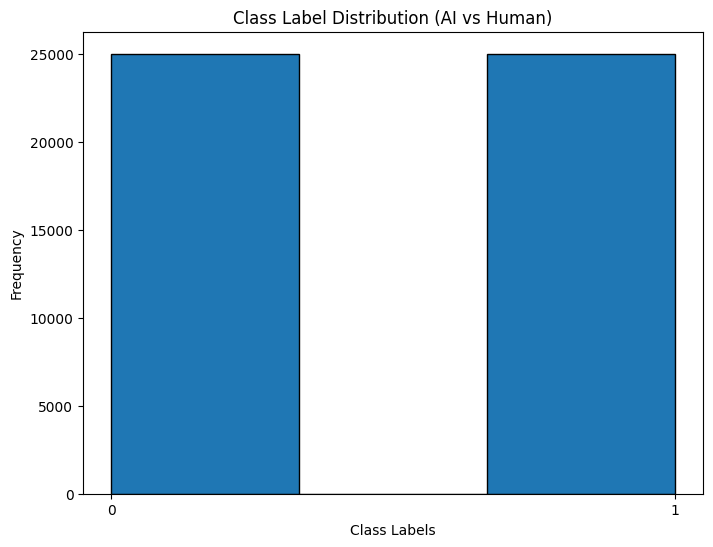

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['generated'], bins=3, edgecolor='black')
plt.title('Class Label Distribution (AI vs Human)')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.show()

##### Due to creating a balanced dataset from sampling, there is no need to add class weights to deal with any imbalance problem.

# Data split

##### Perform a 75/25 training test split, while also creating a validation set, to ensure our model is not overfitting with the specified hyper parameters

In [ ]:
X = np.array(df['text'].tolist())
y = np.array(df['generated'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

In [ ]:
X_val.shape

(5000, 1210)

In [ ]:
X_train.shape

(37500, 1210)

In [ ]:
X_test.shape

(7500, 1210)

# Simple RNN Architecture


In [ ]:
def build_model(hp):
    rnn = Sequential()
    rnn.add(Embedding(input_dim=len(vocabulary),
                      output_dim=300,
                      weights=[embedding_matrix],
                      input_length=len(df['text'][0]),
                      trainable=True))

    # Tune the units in the SimpleRNN layer
    rnn.add(SimpleRNN(units=hp.Int('units', min_value=64, max_value=256, step=64),
                activation='relu',
                kernel_regularizer=l2(hp.Choice('l2', values=[0.001, 0.0001, 0.00001])),
                recurrent_regularizer=l2(hp.Choice('l2', values=[0.001, 0.0001, 0.00001]))))

    # Tune dropout rate
    rnn.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer for binary classification
    rnn.add(Dense(1, activation='sigmoid'))

    # Compile the model with an optimizer and learning rate to tune
    rnn.compile(optimizer= Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return rnn

# Initialize Random Search tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Total number of random configurations to try
    executions_per_trial=1,  # Number of times to train each configuration
    directory='random_search_dir',
    project_name='rnn_random_search'
)

# Define early stopping callback
early_stopping_simple_rnn = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    restore_best_weights=True
)

reduce_lr_simple_rnn = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Perform the search
tuner.search(X_train, y_train,
             epochs=25,
             validation_data=(X_val, y_val),
             batch_size=64,
             callbacks=[early_stopping_simple_rnn, reduce_lr_simple_rnn])

# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Units: {best_hp.get('units')}")
print(f"L2 Regularization: {best_hp.get('l2')}")
print(f"Dropout Rate: {best_hp.get('dropout')}")

Trial 10 Complete [00h 39m 56s]
val_accuracy: 0.9919999837875366

Best val_accuracy So Far: 0.9919999837875366
Total elapsed time: 05h 09m 35s
Best hyperparameters found:
Units: 128
L2 Regularization: 1e-05
Dropout Rate: 0.2


# Simple RN Model

In [ ]:
word = 'example'  # Replace with the desired word
word_index = wv.key_to_index[word]  # Word2Vec mapping to index
initial_embedding = wv[word]  # Word2Vec vector for the word
print("Before training:", initial_embedding)

Before training: [ 2.05078125e-01  7.85827637e-04  3.54003906e-02  1.00585938e-01
 -5.44433594e-02  1.53320312e-01  2.55859375e-01 -2.18750000e-01
 -3.31115723e-03  2.09960938e-01 -2.07031250e-01  1.77001953e-02
  4.29687500e-02 -2.01171875e-01 -1.57226562e-01  1.88476562e-01
 -3.73535156e-02  2.36816406e-02 -2.63671875e-01 -1.33789062e-01
  2.23632812e-01  2.05078125e-01 -5.83496094e-02 -3.11279297e-02
  4.92095947e-04  2.36328125e-01  1.16699219e-01  4.24804688e-02
 -1.33789062e-01  1.84570312e-01  5.02929688e-02 -6.00585938e-02
 -6.22558594e-02  7.61718750e-02  1.48437500e-01  6.10351562e-02
  6.39648438e-02 -2.73437500e-01  1.48437500e-01  8.15429688e-02
  1.57226562e-01 -2.63671875e-02 -1.10839844e-01  3.24707031e-02
 -6.93359375e-02 -3.29589844e-02 -1.34765625e-01  4.32128906e-02
 -1.42578125e-01 -2.50000000e-01  9.86328125e-02 -1.10839844e-01
 -6.98242188e-02 -2.46093750e-01  1.65039062e-01 -9.81445312e-02
 -1.71875000e-01 -1.20117188e-01  1.21582031e-01  1.50390625e-01
  4.1503

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      17,915,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,915,400 (68.34 MB)

 Trainable params: 17,915,400 (68.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 91s 147ms/step - accuracy: 0.6691 - loss: 0.5711 - val_accuracy: 0.9498 - val_loss: 0.1556 - learning_rate: 1.0000e-04
Epoch 2/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 136s 141ms/step - accuracy: 0.9389 - loss: 0.2004 - val_accuracy: 0.9558 - val_loss: 0.2105 - learning_rate: 1.0000e-04
Epoch 3/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 83s 142ms/step - accuracy: 0.9725 - loss: 0.1086 - val_accuracy: 0.9786 - val_loss: 0.0748 - learning_rate: 1.0000e-04
Epoch 4/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 143s 143ms/step - accuracy: 0.9853 - loss: 0.0561 - val_accuracy: 0.9838 - val_loss: 0.0589 - learning_rate: 1.0000e-04
Epoch 5/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - accuracy: 0.9898 - loss: 0.0403 - val_accuracy: 0.9770 - val_loss: 0.0837 - learning_rate: 1.0000e-04
Epoch 6/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 142s 143ms/step - accuracy: 0.9924 - loss: 0.0310 - val_accuracy: 0.9866 - val_loss: 0.0505 - learning_rate: 1.0000e-04
Epoch 7/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 14

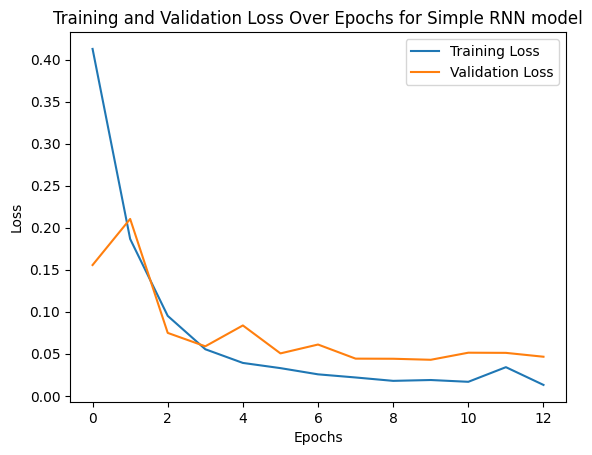

Training time: 1673.5875372886658 seconds


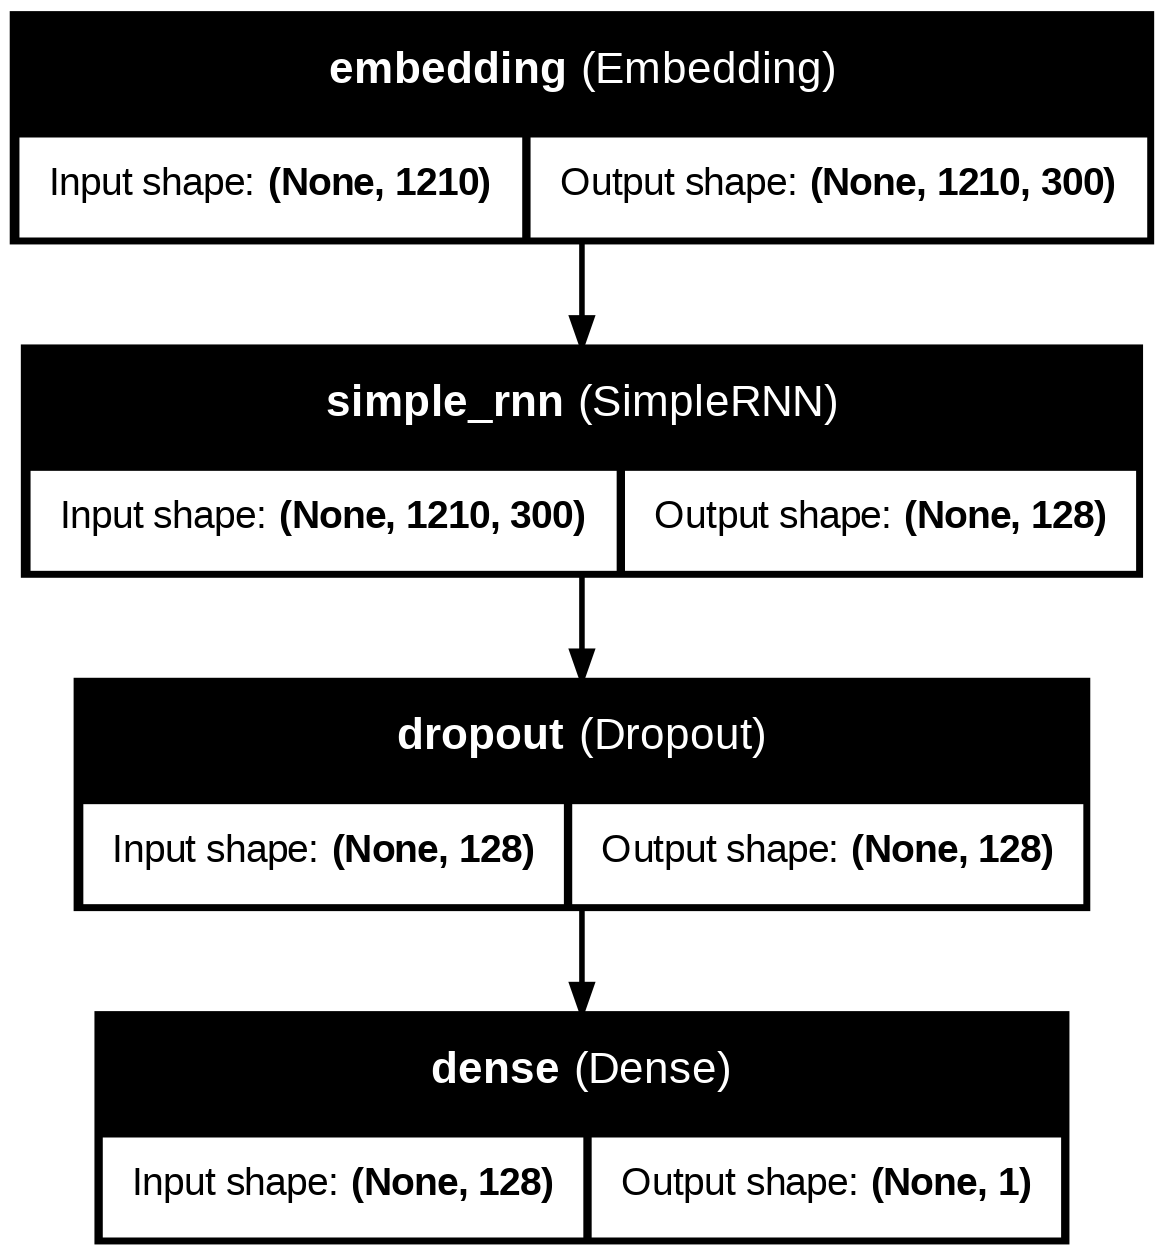

In [ ]:
early_stopping_rnn_hp = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    restore_best_weights=True
)

reduce_lr_rnn_hp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

rnn_hp = Sequential()
rnn_hp.add(Embedding(input_dim=len(vocabulary),
                      output_dim=300,
                      weights=[embedding_matrix],
                      input_length=len(df['text'][0]),
                      trainable=True))
rnn_hp.add(SimpleRNN(units=128,
                activation='relu',
                kernel_regularizer=l2(0.00001),
                recurrent_regularizer=l2(0.00001)))
rnn_hp.add(Dropout(rate=0.2))
rnn_hp.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)

rnn_hp.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

rnn_hp.summary()

start_time = time.time()

# Train the model on the full training data (including validation data if desired)
history = rnn_hp.fit(X_train, y_train,
               epochs=25,
               validation_data=(X_val, y_val),
               batch_size=64,
               callbacks=[early_stopping_rnn_hp, reduce_lr_rnn_hp])

end_time = time.time()

# Optionally evaluate the model on the test set
rnn_loss, rnn_accuracy = rnn_hp.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {rnn_accuracy:.4f}")

y_pred_probs = rnn_hp.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = y_test  # Convert one-hot encoded y_test to class labels

# Calculate precision, recall, and F1 score for each class
print(classification_report(y_true, y_pred, digits=4))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs for Simple RNN model')
plt.legend()
plt.show()

training_time_rnn = end_time - start_time
print(f"Training time: {training_time_rnn} seconds")

plot_model(rnn_hp,
           to_file='rnn_hp.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
embedding_layer = rnn_hp.get_layer('embedding')
trained_embeddings = embedding_layer.get_weights()[0]
updated_embedding = trained_embeddings[word_index]
print("Before training:", updated_embedding)

Before training: [ 2.96993643e-01  7.87844062e-02  3.45534027e-01 -3.68330151e-01
 -2.12725043e-01 -1.49072697e-02 -1.13761835e-02  5.64428568e-02
 -2.40939409e-01  2.19334755e-02  1.85659125e-01 -2.36283362e-01
 -1.99459970e-01  6.94091097e-02 -3.20629090e-01  4.18847680e-01
 -1.20574176e-01  1.22770078e-01 -1.26942128e-01 -7.70245120e-02
  1.08681515e-01  2.22404346e-01  9.33222920e-02  1.12974323e-01
  4.34090614e-01 -1.27899244e-01 -4.58141352e-04  2.55259755e-03
 -9.61757004e-02 -4.25735116e-02  1.52992427e-01 -1.83370754e-01
 -1.98313743e-02  1.71991602e-01  4.62580770e-02  2.47798428e-01
  1.12493910e-01 -1.24370784e-01 -1.48157984e-01  6.07811511e-02
 -1.52793422e-01 -2.07289636e-01  8.11089352e-02 -2.15681881e-01
  4.44817394e-02 -5.61674088e-02 -2.22522855e-01  6.87391832e-02
 -8.85831416e-02  4.03921157e-01  1.53361022e-01 -2.66645942e-03
  1.44891185e-03 -2.92474288e-03 -4.87069376e-02 -2.05081645e-02
 -2.04873309e-01 -1.39600366e-01  2.01719970e-01  8.14073235e-02
 -1.3001

# Embedding change for the word exmaple

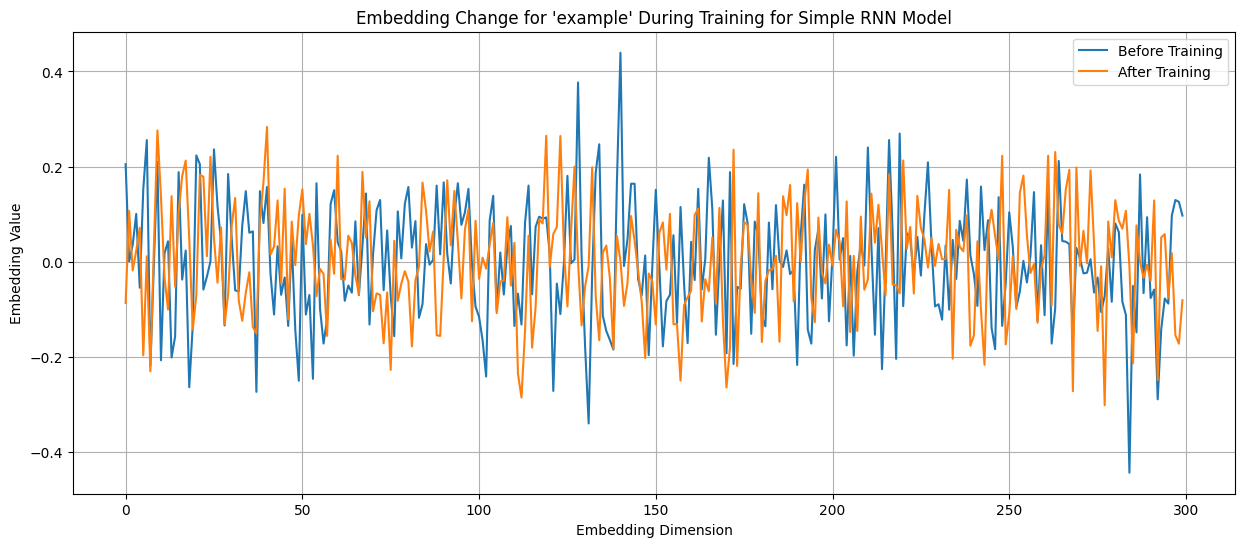

In [ ]:
before_training = initial_embedding  # Embedding from Word2Vec
after_training = updated_embedding  # Embedding from the trained model

# Ensure both are NumPy arrays for plotting
before_training = np.array(before_training)
after_training = np.array(after_training)

# Plot the values
plt.figure(figsize=(15, 6))
dimensions = range(len(before_training))  # x-axis for embedding dimensions

# Before training
plt.plot(dimensions, before_training, label="Before Training")

# After training
plt.plot(dimensions, after_training, label="After Training")

# Add labels and legend
plt.title(f"Embedding Change for 'example' During Training for Simple RNN Model")
plt.xlabel("Embedding Dimension")
plt.ylabel("Embedding Value")
plt.legend()
plt.grid(True)
plt.show()

# Embedding change for the word school

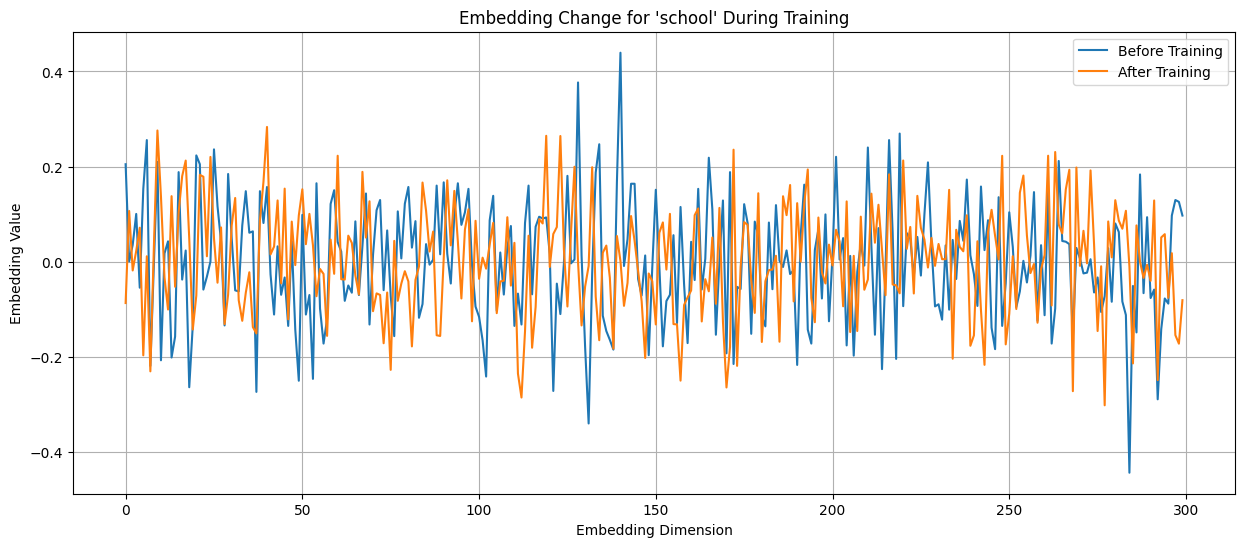

In [ ]:
word = 'school'  # Replace with the desired word
word_index = wv.key_to_index[word]  # Word2Vec mapping to index

embedding_layer = rnn_hp.get_layer('embedding')
trained_embeddings = embedding_layer.get_weights()[0]
updated_embedding = trained_embeddings[word_index]

before_training = initial_embedding  # Embedding from Word2Vec
after_training = updated_embedding  # Embedding from the trained model

# Ensure both are NumPy arrays for plotting
before_training = np.array(before_training)
after_training = np.array(after_training)

# Plot the values
plt.figure(figsize=(15, 6))
dimensions = range(len(before_training))  # x-axis for embedding dimensions

# Before training
plt.plot(dimensions, before_training, label="Before Training")

# After training
plt.plot(dimensions, after_training, label="After Training")

# Add labels and legend
plt.title(f"Embedding Change for 'school' During Training")
plt.xlabel("Embedding Dimension")
plt.ylabel("Embedding Value")
plt.legend()
plt.grid(True)
plt.show()

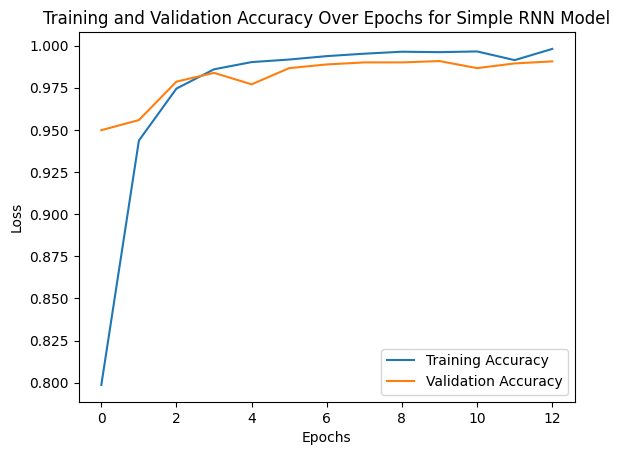

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy Over Epochs for Simple RNN Model')
plt.legend()
plt.show()

In [ ]:
rnn_hp.count_params()

17970441

# Stacked - Bi-Directional RNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      17,915,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,915,400 (68.34 MB)

 Trainable params: 17,915,400 (68.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
293/293 ━━━━━━━━━━━━━━━━━━━━ 182s 584ms/step - accuracy: 0.5759 - loss: 0.6455 - val_accuracy: 0.9080 - val_loss: 0.2872 - learning_rate: 1.0000e-04
Epoch 2/25
293/293 ━━━━━━━━━━━━━━━━━━━━ 191s 569ms/step - accuracy: 0.9156 - loss: 0.2629 - val_accuracy: 0.9520 - val_loss: 0.1574 - learning_rate: 1.0000e-04
Epoch 3/25
293/293 ━━━━━━━━━━━━━━━━━━━━ 167s 568ms/step - accuracy: 0.9684 - loss: 0.1179 - val_accuracy: 0.9772 - val_loss: 0.0810 - learning_rate: 1.0000e-04
Epoch 4/25
293/293 ━━━━━━━━━━━━━━━━━━━━ 166s 567ms/step - accuracy: 0.9796 - loss: 0.0764 - val_accuracy: 0.9808 - val_loss: 0.0680 - learning_rate: 1.0000e-04
Epoch 5/25
293/293 ━━━━━━━━━━━━━━━━━━━━ 167s 568ms/step - accuracy: 0.9808 - loss: 0.0698 - val_accuracy: 0.9244 - val_loss: 0.1934 - learning_rate: 1.0000e-04
Epoch 6/25
293/293 ━━━━━━━━━━━━━━━━━━━━ 201s 564ms/step - accuracy: 0.9828 - loss: 0.0630 - val_accuracy: 0.9784 - val_loss: 0.0830 - learning_rate: 1.0000e-04
Epoch 7/25
293/293 ━━━━━━━━━━━━━━━━━━━━ 

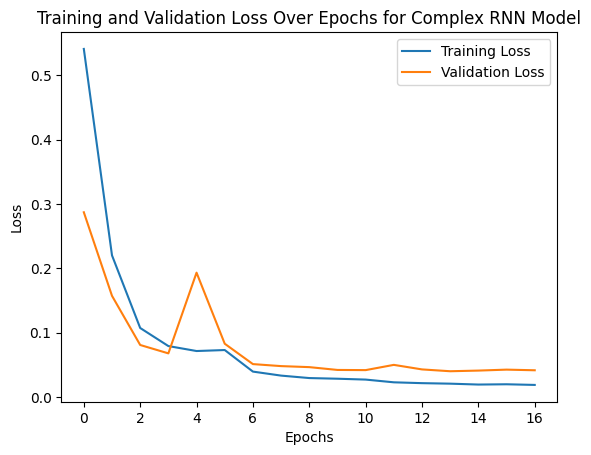

Training time: 3253.59112405777 seconds


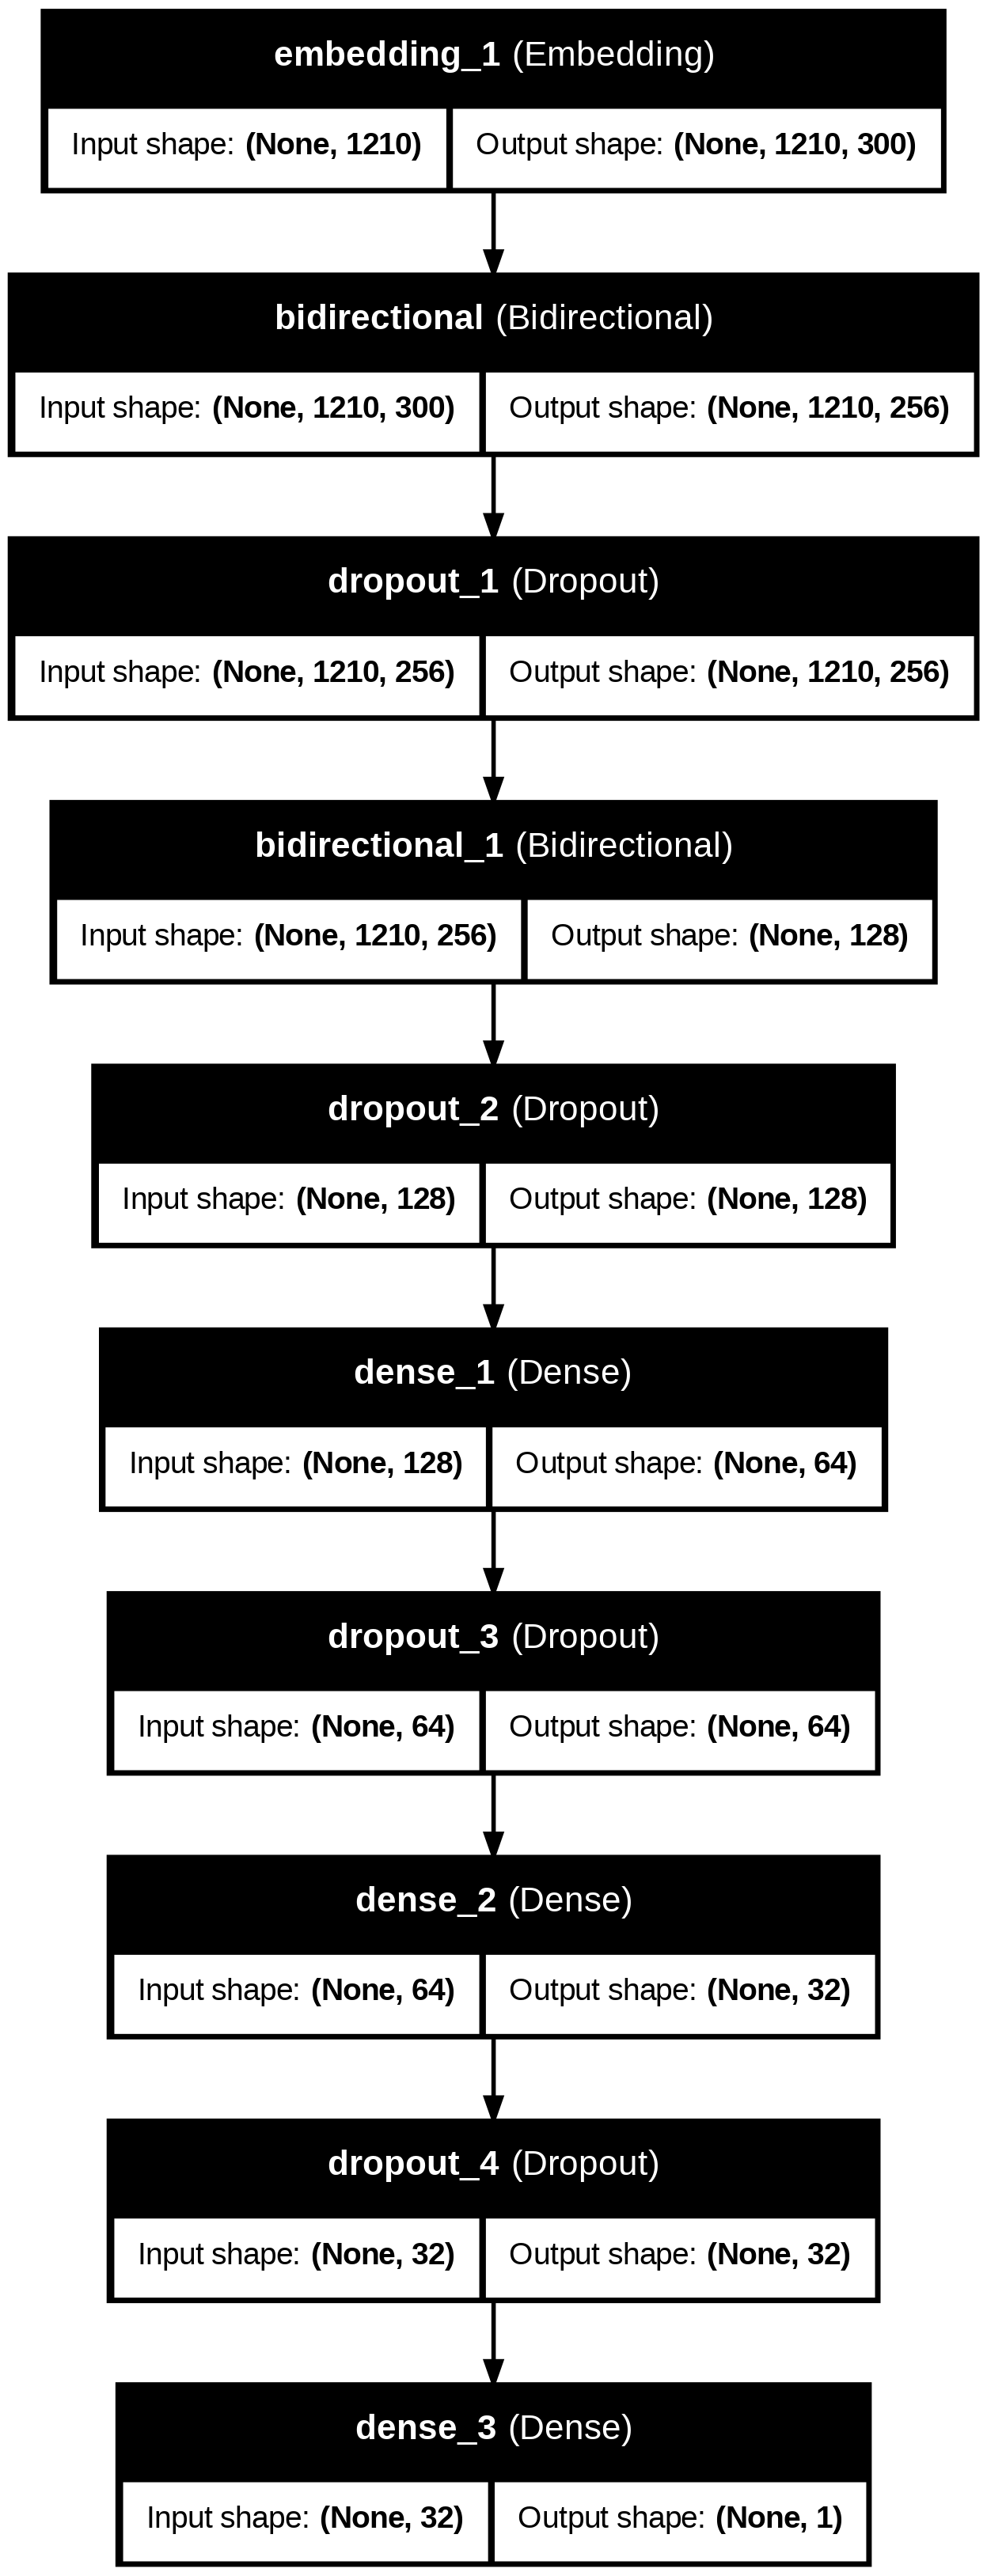

In [ ]:
early_stopping_rnn_bi = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs to wait for improvement
    mode='min',
    restore_best_weights=True  # Restore weights from the best epoch
)
reduce_lr_rnn_bi = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

rnn_bi = Sequential()
rnn_bi.add(Embedding(input_dim=len(vocabulary), output_dim=300, input_length=len(df['text'][0]), weights=[embedding_matrix], trainable=True))
rnn_bi.add(Bidirectional(SimpleRNN(128, activation='relu', return_sequences=True)))
rnn_bi.add(Dropout(0.2))
rnn_bi.add(Bidirectional(SimpleRNN(64, activation='relu', return_sequences=False)))
rnn_bi.add(Dropout(0.2))
rnn_bi.add(Dense(64, activation='relu'))
rnn_bi.add(Dropout(0.2))
rnn_bi.add(Dense(32, activation='relu'))
rnn_bi.add(Dropout(0.2))
rnn_bi.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)

rnn_bi.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display model summary
rnn_bi.summary()

start_time = time.time()

# Train the model for 30 epochs
history = rnn_bi.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=128, callbacks=[early_stopping_rnn_bi, reduce_lr_rnn_bi])

end_time = time.time()

# Optionally evaluate the model on the test set
rnn_bi_loss, rnn_bi_accuracy = rnn_bi.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {rnn_bi_accuracy:.4f}")

y_pred_probs = rnn_bi.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = y_test  # Convert one-hot encoded y_test to class labels

# Calculate precision, recall, and F1 score for each class
print(classification_report(y_true, y_pred, digits=4))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs for Complex RNN Model')
plt.legend()
plt.show()

training_time_rnn_bi = end_time - start_time
print(f"Training time: {training_time_rnn_bi} seconds")

plot_model(rnn_bi,
           to_file='rnn_bi.png',
           show_shapes=True,
           show_layer_names=True)

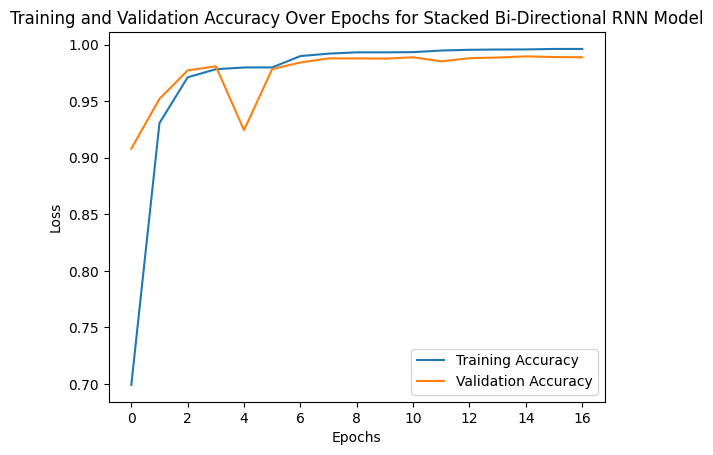

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy Over Epochs for Stacked Bi-Directional RNN Model')
plt.legend()
plt.show()

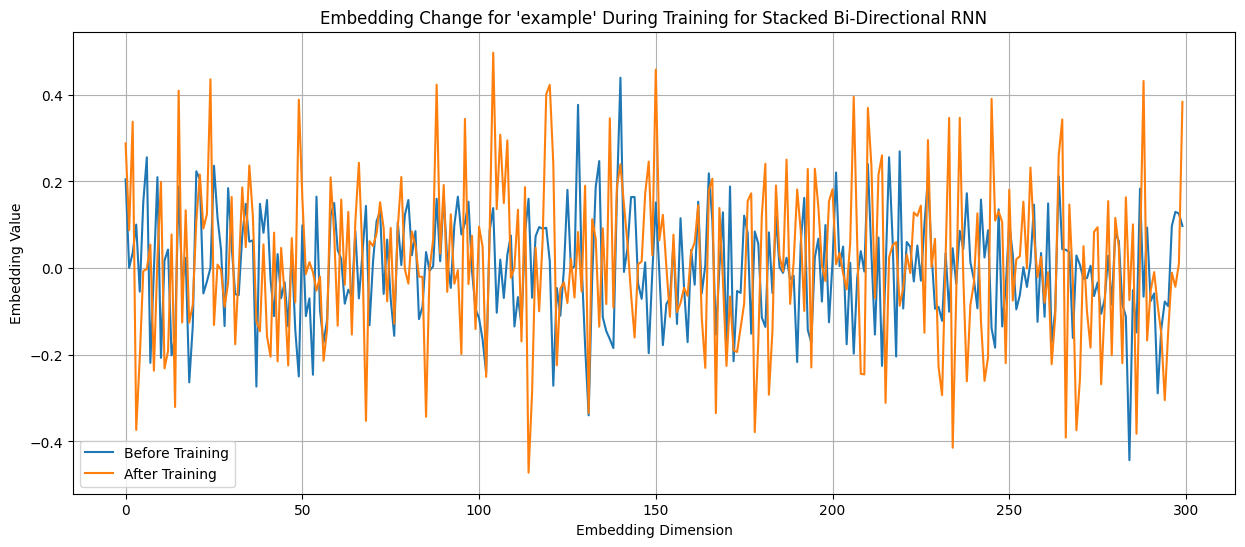

In [ ]:
word = 'example'  # Replace with the desired word
word_index = wv.key_to_index[word]  # Word2Vec mapping to index

embedding_layer = rnn_bi.get_layer('embedding_1')
trained_embeddings = embedding_layer.get_weights()[0]
updated_embedding = trained_embeddings[word_index]

before_training = initial_embedding  # Embedding from Word2Vec
after_training = updated_embedding  # Embedding from the trained model

# Ensure both are NumPy arrays for plotting
before_training = np.array(before_training)
after_training = np.array(after_training)

# Plot the values
plt.figure(figsize=(15, 6))
dimensions = range(len(before_training))  # x-axis for embedding dimensions

# Before training
plt.plot(dimensions, before_training, label="Before Training")

# After training
plt.plot(dimensions, after_training, label="After Training")

# Add labels and legend
plt.title(f"Embedding Change for 'example' During Training for Stacked Bi-Directional RNN")
plt.xlabel("Embedding Dimension")
plt.ylabel("Embedding Value")
plt.legend()
plt.grid(True)
plt.show()

# Comparing embeddings for complex rnn vs simple rnn

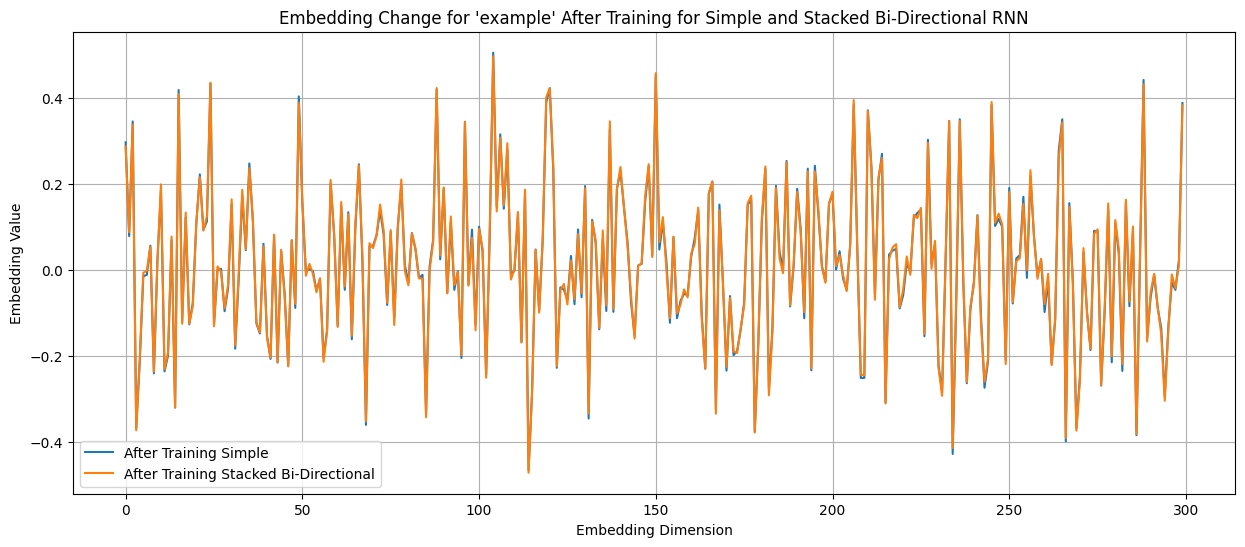

In [ ]:
word = 'example'  # Replace with the desired word
word_index = wv.key_to_index[word]  # Word2Vec mapping to index

embedding_layer = rnn_hp.get_layer('embedding')
trained_embeddings = embedding_layer.get_weights()[0]
updated_embedding = trained_embeddings[word_index]

embedding_layer_bi = rnn_bi.get_layer('embedding_1')
trained_embeddings = embedding_layer_bi.get_weights()[0]
updated_embedding_bi = trained_embeddings[word_index]

after_training = updated_embedding  # Embedding from Word2Vec
after_training_bi = updated_embedding_bi  # Embedding from the trained model

# Ensure both are NumPy arrays for plotting
after_training = np.array(after_training)
after_training_bi = np.array(after_training_bi)

# Plot the values
plt.figure(figsize=(15, 6))
dimensions = range(len(before_training))  # x-axis for embedding dimensions

# Before training
plt.plot(dimensions, after_training, label="After Training Simple")

# After training
plt.plot(dimensions, after_training_bi, label="After Training Stacked Bi-Directional")

# Add labels and legend
plt.title(f"Embedding Change for 'example' After Training for Simple and Stacked Bi-Directional RNN")
plt.xlabel("Embedding Dimension")
plt.ylabel("Embedding Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
rnn_bi.count_params()

18076681

# Transformer Architecture

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[embedding_matrix])
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1210)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 1210, 300)           │      18,278,400 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 1210, 300)           │         733,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           4,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,016,449 (72.54 MB)

 Trainable params: 19,016,449 (72.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.7049 - loss: 0.5353 - val_accuracy: 0.9314 - val_loss: 0.1985 - learning_rate: 1.0000e-04
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.9503 - loss: 0.1442 - val_accuracy: 0.9782 - val_loss: 0.0598 - learning_rate: 1.0000e-04
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9806 - loss: 0.0695 - val_accuracy: 0.9874 - val_loss: 0.0390 - learning_rate: 1.0000e-04
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9897 - loss: 0.0410 - val_accuracy: 0.9906 - val_loss: 0.0319 - learning_rate: 1.0000e-04
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9937 - loss: 0.0232 - val_accuracy: 0.9902 - val_loss: 0.0327 - learning_rate: 1.0000e-04
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9957 - loss: 0.0174 - val_accuracy: 0.9906 - val_loss: 0.0344 - learning_rate: 1.0000e-04
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - acc

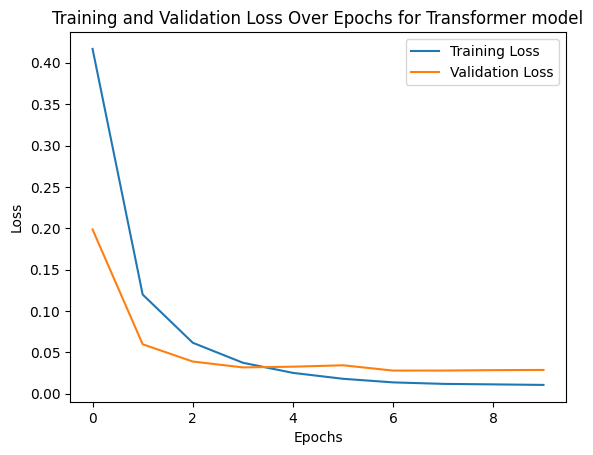

Training time: 2702.532972574234 seconds


In [ ]:
early_stopping_transformer = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs to wait for improvement
    mode='min',
    restore_best_weights=True  # Restore weights from the best epoch
)
reduce_lr_transformer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

num_heads = 2  # Number of attention heads
ff_dim = 16  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(len(df['text'][0]),))

embedding_layer = TokenAndPositionEmbedding(len(df['text'][0]), len(vocabulary), 300)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(300, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(ff_dim, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

transformer = keras.Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=0.0001)

transformer.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

transformer.summary()

start_time = time.time()
history = transformer.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=256, callbacks=[early_stopping_transformer, reduce_lr_transformer])
end_time = time.time()

transformer_loss, transformer_accuracy = transformer.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {transformer_accuracy:.4f}")

y_pred_probs = transformer.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = y_test  # Convert one-hot encoded y_test to class labels

# Calculate precision, recall, and F1 score for each class
print(classification_report(y_true, y_pred, digits=4))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs for Transformer model')
plt.legend()
plt.show()
training_time_transformer= end_time - start_time
print(f"Training time: {training_time_transformer} seconds")

In [ ]:
transformer.save('transformer_model.h5')

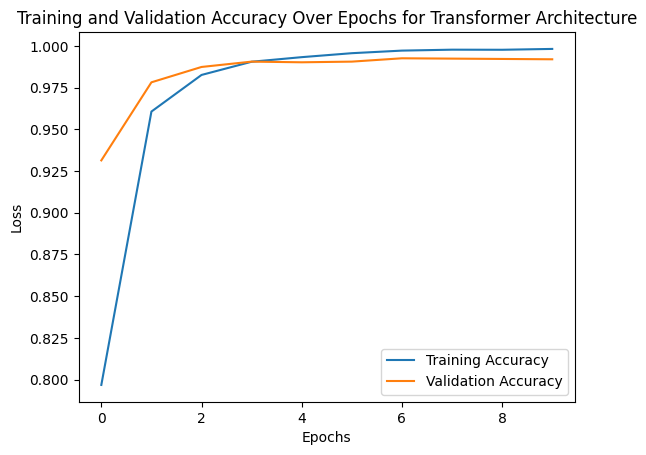

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy Over Epochs for Transformer Architecture')
plt.legend()
plt.show()

In [ ]:
transformer.count_params()

19016449

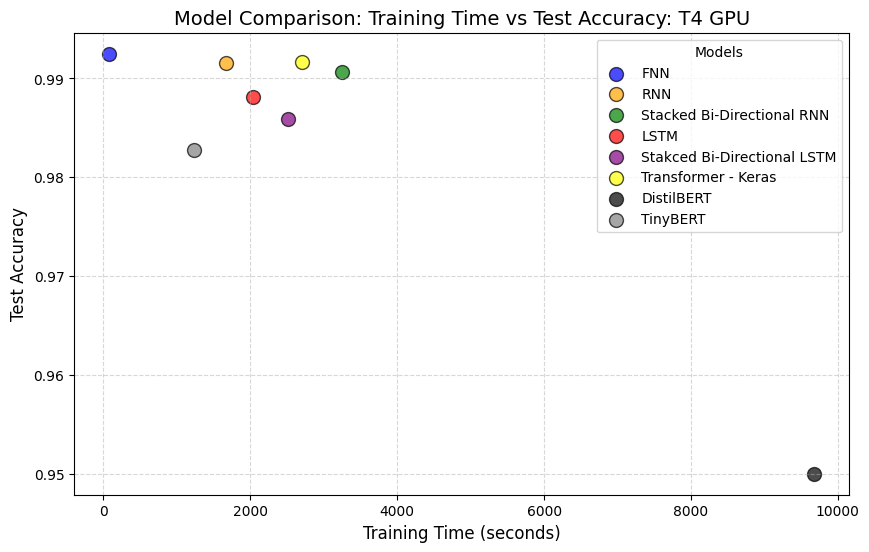

In [ ]:
models = ["FNN", "RNN", "Stacked Bi-Directional RNN", "LSTM", "Stakced Bi-Directional LSTM", "Transformer - Keras", "DistilBERT", "TinyBERT"]
training_times = [80.30, 1673, 3253, 2030, 2515, 2702, 9674, 1237]  # in seconds
test_accuracies = [0.9925, 0.9916, 0.9907, 0.9881, 0.9859, 0.9917, 0.95, 0.9828]  # as percentages (0 to 1 scale)

# Define colors for each model
colors = ["blue", "orange", "green", "red", "purple", "yellow", "black", "gray"]

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot each model with a unique color
for i, model in enumerate(models):
    plt.scatter(
        training_times[i], test_accuracies[i],
        label=model,  # Add model to legend
        color=colors[i], s=100, edgecolors="k", alpha=0.7
    )

# Add titles and labels
plt.title("Model Comparison: Training Time vs Test Accuracy: T4 GPU", fontsize=14)
plt.xlabel("Training Time (seconds)", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)

# Add legend
plt.legend(title="Models", fontsize=10, loc="upper right")

# Show grid for better readability
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.show()

# Metric plots for FNN and RNN Architectures

<ipython-input-16-a53db1d88f7f>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Accuracy", y="Architecture", data=df, palette="viridis", orient="h")


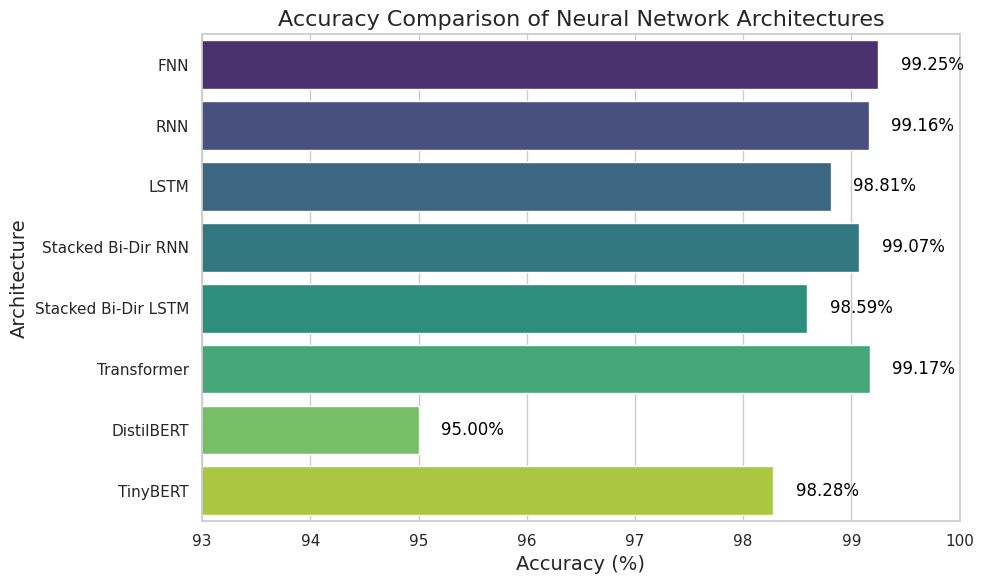

In [ ]:
# Example data: Replace with your actual data
data = {
    "Architecture": [
        "FNN", "RNN", "LSTM", "Stacked Bi-Dir RNN",
        "Stacked Bi-Dir LSTM", "Transformer", "DistilBERT", "TinyBERT"
    ],
    "Accuracy": [99.25, 99.16, 98.81, 99.07, 98.59, 99.17, 95.00, 98.28]
}
# Convert data to a DataFrame
df = pd.DataFrame(data)

# Set a nice style
sns.set_theme(style="whitegrid")

# Create a barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Accuracy", y="Architecture", data=df, palette="viridis", orient="h")

# Add accuracy values to the bars
for i, acc in enumerate(df["Accuracy"]):
    ax.text(acc + 0.5, i, f"{acc:.2f}%", color='black', ha="center", va="center")

ax.set_xlim(93, 100)

# Title and labels
plt.title("Accuracy Comparison of Neural Network Architectures", fontsize=16)
plt.xlabel("Accuracy (%)", fontsize=14)
plt.ylabel("Architecture", fontsize=14)

# Show plot
plt.tight_layout()
plt.show()